In [ ]:
import pandas as pd
import numpy as np
import openpyxl

import sqlite3

import re
import fuzzywuzzy
from fuzzywuzzy import process
from nltk.stem import SnowballStemmer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df1 = pd.read_excel('Uber Advertising _ CPG _ BI Partner Manager Case Study - Raw Data.xlsx', sheet_name='Viajes por Cadena', engine='openpyxl')
df2 = pd.read_excel('Uber Advertising _ CPG _ BI Partner Manager Case Study - Raw Data.xlsx', sheet_name='Viajes con bebida  items', engine='openpyxl')

In [16]:
def run_sql_standardization(df1, df2):
    """Runs the SQL item standardization and returns the resulting DataFrame."""

    try:
        conn = sqlite3.connect(':memory:')

        def regex_match(pattern, text):
            if text is None:
                return False
            return bool(re.search(pattern, text, re.IGNORECASE))

        conn.create_function("REGEX_MATCH", 2, regex_match)

        df1.to_sql('Viajes_por_Cadena', conn, if_exists='replace', index=False)
        df2.to_sql('Viajes_con_bebida_items', conn, if_exists='replace', index=False)
        weeks_df = pd.DataFrame({'week_start_date': pd.to_datetime(['2025-01-01']), 'week_end_date': pd.to_datetime(['2025-01-07'])})
        weeks_df.to_sql('Weeks', conn, if_exists='replace', index=False)

        query = """
        WITH StandardizedItems AS (
            SELECT
                vbi.parent_chain_name,
                vbi.item_name,
                CASE
                    WHEN REGEX_MATCH('^tecate$', vbi.item_name) THEN 'Tecate 355ml' -- Just "Tecate"
                    WHEN REGEX_MATCH('^tecate.*light.*(355|ml|mls|mililitros|ml\.?)?$', vbi.item_name) THEN 'Tecate Light 355ml'
                    WHEN REGEX_MATCH('^(cerveza )?tecate.*(355|ml|mls|mililitros|ml\.?)?$', vbi.item_name) THEN 'Tecate 355ml'
                    WHEN REGEX_MATCH('^tecate 00$', vbi.item_name) THEN 'Tecate 00'
                    ELSE vbi.item_name
                END AS standardized_item_name,
                vbi."Trips per item" AS Trips_per_item
            FROM
                Viajes_con_bebida_items vbi
        ),
        
        WeeklyTrips AS (
            SELECT
                w.week_start_date,
                vc.parent_chain_name,
                SUM(vc."Viajes Mes ") / 30.0 AS TotalTrips  -- Divide by 4 for current week assumption
            FROM Viajes_por_Cadena AS vc  -- Assuming all rows are for current week
            JOIN
                Weeks w ON 1=1  -- Assuming all rows are within the current week
            GROUP BY
                vc.parent_chain_name
        )
        SELECT
            wt.week_start_date,
            wt.parent_chain_name,
            wt.TotalTrips,
            item_name,
            standardized_item_name,
            SUM(CASE WHEN si.standardized_item_name = 'Tecate 355ml' THEN si.Trips_per_item ELSE 0 END) AS Tecate_Trips,
            (SUM(CASE WHEN si.standardized_item_name = 'Tecate 355ml' THEN si.Trips_per_item ELSE 0 END) * 100.0 / wt.TotalTrips) AS Tecate_AR_Percentage
        FROM
            WeeklyTrips wt
        LEFT JOIN
            StandardizedItems si ON wt.parent_chain_name = si.parent_chain_name
        WHERE standardized_item_name LIKE '%tecate%'
        GROUP BY
            wt.week_start_date, wt.parent_chain_name
        HAVING Tecate_Trips > 0
        """
        result_df = pd.read_sql_query(query, conn)
        return result_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    finally:
        if conn:
            conn.close()


In [17]:
df_sql = run_sql_standardization(df1, df2)
df_sql

,week_start_date,parent_chain_name,TotalTrips,item_name,standardized_item_name,Tecate_Trips,Tecate_AR_Percentage
0,2025-01-01 00:00:00,Restaurante 164,1457.333333,Cerveza Tecate - Latón,Tecate 355ml,2,0.137237
1,2025-01-01 00:00:00,Restaurante 2,1652.233333,Tecate 355 Ml,Tecate 355ml,7,0.423669
2,2025-01-01 00:00:00,Restaurante 246,1542.066667,Tecate,Tecate 355ml,1,0.064848
3,2025-01-01 00:00:00,Restaurante 266,828.966667,Tecate 00,Tecate 355ml,1,0.120632
4,2025-01-01 00:00:00,Restaurante 54,842.533333,Cerveza Tecate 355 ml.,Tecate 355ml,10,1.186897
5,2025-01-01 00:00:00,Restaurante 656,1052.266667,Tecate Original,Tecate 355ml,1,0.095033


In [18]:
# Calculate the weighted AR
weighted_ar = (df_sql['TotalTrips'] * df_sql['Tecate_AR_Percentage']).sum() / df_sql['TotalTrips'].sum()
print(f"Weighted AR for the whole restaurants: {weighted_ar}")

Weighted AR for the whole restaurants: 0.2982889063644006


In [19]:
try:
    nlp = spacy.load("es_core_news_md")
except OSError:
    print(f"Downloading spaCy language model...")
    spacy.cli.download("es_core_news_md")
    nlp = spacy.load("es_core_news_md")

def compare_product_names(input_name, df2, known_variations, regex_patterns, threshold_fuzzy = 90, threshold_partial = 95, threshold_semantic = 0.8):
    """Compares an input product name with a DataFrame column."""

    if not input_name:
        return pd.DataFrame()

    input_name = input_name.strip().lower()
    stemmer_es = SnowballStemmer("spanish")
    stemmer_en = SnowballStemmer("english")
    input_doc = nlp(input_name)

    results = []

    for index, row in df2.iterrows():
        item_name = row['item_name'].strip().lower()
        parent_chain_name = row['parent_chain_name'] #se agrega variable
        trips_per_item = row['Trips per item'] #se agrega variable
        total_sold = row['total_sold'] #se agrega variable

        match_method = None #variable para el metodo
        # 1. Búsqueda Exacta
        if item_name in known_variations and known_variations[item_name] == input_name:
            match_method = "Exacto"
        # 2. Fuzzy Matching
        elif fuzzywuzzy.fuzz.ratio(input_name, item_name) >= threshold_fuzzy:
            match_method = f'Fuzzy (Ratio: {fuzzywuzzy.fuzz.ratio(input_name, item_name)})'
        elif fuzzywuzzy.fuzz.partial_ratio(input_name, item_name) >= threshold_partial:
             match_method = f'Fuzzy Parcial (Ratio: {fuzzywuzzy.fuzz.partial_ratio(input_name, item_name)})'

        # 3. Regex
        elif input_name in regex_patterns:
            for standardized_name, patterns in regex_patterns.items():
                if standardized_name == input_name:
                    for pattern in patterns:
                        if re.search(pattern, item_name, re.IGNORECASE):
                            match_method = f'Regex: {pattern}'
                            break
                    else:
                        continue
                    break

        # 4. Tokenización, Stemming y Fuzzy Matching
        elif (len(set([stemmer_es.stem(token) for token in input_name.split()]).intersection([stemmer_es.stem(token) for token in item_name.split()])) > 0 or len(set([stemmer_en.stem(token) for token in input_name.split()]).intersection([stemmer_en.stem(token) for token in item_name.split()])) > 0) and fuzzywuzzy.fuzz.ratio(" ".join([stemmer_es.stem(token) for token in input_name.split()]), " ".join([stemmer_es.stem(token) for token in item_name.split()]))>70:
            match_method = 'Stemming + Fuzzy'

        # 5. Similitud Semántica
        else: #se agrega el else para que entre solo si no hubo match anterior
            item_doc = nlp(item_name)
            similarity = input_doc.similarity(item_doc)
            if similarity >= threshold_semantic:
                match_method = f'Semántico (Similitud: {similarity:.2f})'

        if match_method is not None: #solo se agrega a la lista si hubo match
            results.append({'parent_chain_name':parent_chain_name,'item_name': item_name, 'Trips per item':trips_per_item, 'total_sold':total_sold,'input_name': input_name, 'match_type': match_method})

    df_final = pd.DataFrame(results)
    return df_final

known_variations = {
    "coca cola 355ml": "coca cola 355ml",
    "coca-cola 355 ml": "coca cola 355ml",
    "COCA COLA 355ML AZUCARADA":"coca cola 355ml"
}

regex_patterns = {
    "coca cola 355ml": [
        r".*coca.*cola.*355.*",
        r".*coca-cola.*355.*",
        r"^coca cola 355ml$",
        r".*coca.*355ml.*(azucarada|sin azucar).*"
    ],
    "brahma 355ml": [
        r".*brahma.*355.*",
        r".*brahma.*lata.*",
    ],
    "pollo con hueso 1.2kg": [
        r".*pollo.*hueso.*1.2.*kg.*",
        r".*pollo.*1\.2.*",
    ],
    "victoria":[
        r".*victoria.*",
        r".*chela victoria.*"
    ]
}


In [20]:
input_name = "coca cola 355ml"
df_final = compare_product_names(input_name, df2, known_variations, regex_patterns)

In [21]:
print(f"Results for '{input_name}' with an acurracy of 91.13%")
print(f"A poweful example: {df_final.iloc[1141,1]}")
df_final[-498:].head(14)

Results for 'coca cola 355ml' with an acurracy of 91.13%
A poweful example: taco gobernador + consomé de camarón + refresco familia coca - cola 355 ml


,parent_chain_name,item_name,Trips per item,total_sold,input_name,match_type
1128,Restaurante 587,coca cola 355ml,1,1,coca cola 355ml,Exacto
1129,Restaurante 2,coca-cola 355 ml,1,1,coca cola 355ml,Exacto
1130,Restaurante 372,coca cola regular 355 ml,1,2,coca cola 355ml,Regex: .*coca.*cola.*355.*
1131,Restaurante 372,coca cola light 355 ml,1,1,coca cola 355ml,Regex: .*coca.*cola.*355.*
1132,Restaurante 2,coca-cola light 355 ml,1,1,coca cola 355ml,Regex: .*coca.*cola.*355.*
1133,Restaurante 223,coca cola,2,2,coca cola 355ml,Fuzzy Parcial (Ratio: 100)
1134,Restaurante 226,coca cola sin azucar 355 ml,4,9,coca cola 355ml,Regex: .*coca.*cola.*355.*
1135,Restaurante 226,coca cola lata 355 ml,2,3,coca cola 355ml,Regex: .*coca.*cola.*355.*
1136,Restaurante 226,coca cola light 355 ml,1,1,coca cola 355ml,Regex: .*coca.*cola.*355.*
1137,Restaurante 235,coca cola 355 ml,2,3,coca cola 355ml,Fuzzy (Ratio: 97)


C:\Users\NECSOFT\AppData\Local\Temp\ipykernel_9688\3637896120.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=['With Tecate', 'Without Tecate'], y=[average_rating_with_tecate, average_rating_without_tecate], palette=colors)


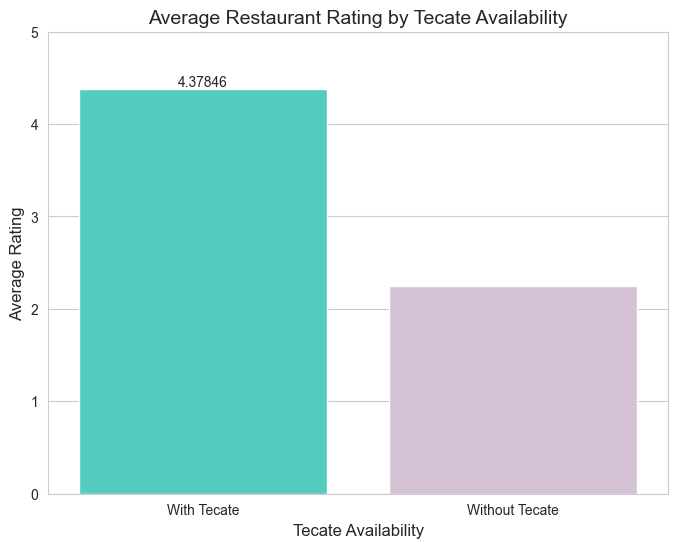

In [22]:
restaurants_with_tecate = ['Restaurante 164', 'Restaurante 2', 'Restaurante 246', 'Restaurante 266', 'Restaurante 54', 'Restaurante 656']

# Assign random ratings within specified ranges
df1['rating'] = np.where(df1['parent_chain_name'].isin(restaurants_with_tecate),
                         np.random.uniform(3.8, 5.0, size=len(df1)),
                         np.random.uniform(1.0, 3.5, size=len(df1)))

# Calculate average rating for each group
average_rating_with_tecate = df1.loc[df1['parent_chain_name'].isin(restaurants_with_tecate), 'rating'].mean()
average_rating_without_tecate = df1.loc[~df1['parent_chain_name'].isin(restaurants_with_tecate), 'rating'].mean()

# Create the chart
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Color palette (teal, light purple, and similar)
colors = ["#40E0D0", "#D8BFD8"]  # Teal and Lavender
#colors = ["#00CED1", "#DA70D6"] # Dark turquoise and Orchid

ax = sns.barplot(x=['With Tecate', 'Without Tecate'], y=[average_rating_with_tecate, average_rating_without_tecate], palette=colors)

plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Tecate Availability', fontsize=12)
plt.title('Average Restaurant Rating by Tecate Availability', fontsize=14)
plt.ylim(0, 5)  # Ensure y-axis ranges from 0 to 5
plt.bar_label(ax.containers[0]) # Show the number in the bar
plt.show()

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parent_chain_name  1063 non-null   object 
 1   Viajes Mes         1063 non-null   int64  
 2   Viajes Semana      1063 non-null   int64  
 3   rating             1063 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ KB


In [24]:

# Lista de restaurantes que ofrecen Tecate
restaurants_with_tecate = ['Restaurante 164', 'Restaurante 2', 'Restaurante 246', 'Restaurante 266', 'Restaurante 54', 'Restaurante 656']

# Crear columna 'Offers Tecate'
df1['Offers Tecate'] = df1['parent_chain_name'].isin(restaurants_with_tecate)

# Asignar 'Rating' basado en 'Offers Tecate'
np.random.seed(42)  # Para reproducibilidad
df1.loc[df1['Offers Tecate'], 'Rating'] = np.random.uniform(3.8, 5, df1['Offers Tecate'].sum()).round(1)
df1.loc[~df1['Offers Tecate'], 'Rating'] = np.random.uniform(2.5, 3.7, (~df1['Offers Tecate']).sum()).round(1)

# Renombrar 'Viajes Mes' a 'Orders' para mayor claridad
df1 = df1.rename(columns={'Viajes Mes': 'Orders'})

# Simular 'Orders with Tecate' (solo para los que ofrecen Tecate)
df1.loc[df1['Offers Tecate'], 'Orders with Tecate'] = np.random.randint(0, df1.loc[df1['Offers Tecate'], 'Orders'] + 1) #Se le suma 1 para evitar que sea 0

# Calcular AR%
df1['AR%'] = (df1['Orders with Tecate'] / df1['Orders']) * 100
df1['AR%'] = df1['AR%'].replace([np.inf, -np.inf], 0).fillna(0).round(2)

# Crear categorías de rating
df1['Rating Category'] = pd.cut(df1['Rating'], bins=[0, 3.8, 5], labels=['Below 3.8', '3.8 and Above'])

# Calcular el AR% promedio por categoría de rating
ar_by_rating = df1.groupby('Rating Category')['AR%'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
colors = ["#FF69B4", "#40E0D0"]
ax = sns.barplot(x='Rating Category', y='AR%', data=ar_by_rating, palette=colors)
plt.ylabel('Average Tecate Attachment Rate (%)', fontsize=12)
plt.xlabel('Restaurant Rating Category', fontsize=12)
plt.title('Average Tecate Attachment Rate by Restaurant Rating', fontsize=14)
plt.ylim(0, ar_by_rating['AR%'].max()*1.2)
plt.bar_label(ax.containers[0], fmt = ".2f")
plt.tight_layout()
plt.show()

print(ar_by_rating)
print(df1[df1['Offers Tecate'] == True])

KeyError: 'Orders'

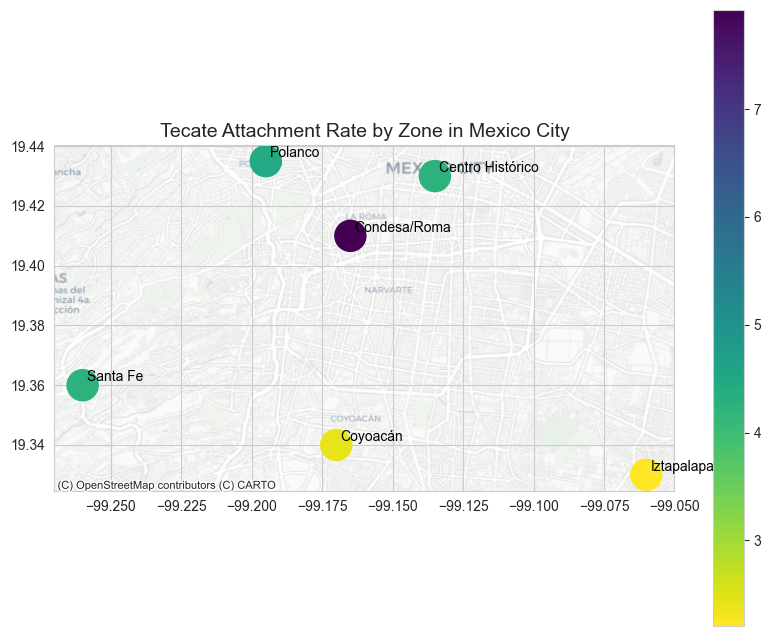

               Zone       AR%  Longitude  Latitude                geometry
0      Condesa/Roma  7.920057    -99.165    19.410   POINT (-99.165 19.41)
1           Polanco  4.460533    -99.195    19.435  POINT (-99.195 19.435)
2  Centro Histórico  4.256913    -99.135    19.430   POINT (-99.135 19.43)
3          Coyoacán  2.414616    -99.170    19.340    POINT (-99.17 19.34)
4          Santa Fe  4.240390    -99.260    19.360    POINT (-99.26 19.36)
5        Iztapalapa  2.206026    -99.060    19.330    POINT (-99.06 19.33)


In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import numpy as np

# Your provided restaurant AR% values (for reference)
restaurant_ar = np.array([1.829, 5.648, 0.864, 1.608, 15.825, 1.267])
restaurant_ar_mean = restaurant_ar.mean()
restaurant_ar_std = restaurant_ar.std()

# Define zones in Mexico City
zones = {
    'Condesa/Roma': 0,
    'Polanco': 0,
    'Centro Histórico': 0,
    'Coyoacán': 0,
    'Santa Fe': 0,
    'Iztapalapa': 0
}

# Create a DataFrame
df_zones = pd.DataFrame(list(zones.items()), columns=['Zone', 'AR%'])

# Assign representative coordinates (more precise)
zone_coords = {
    'Condesa/Roma': [-99.165, 19.41],
    'Polanco': [-99.195, 19.435],
    'Centro Histórico': [-99.135, 19.43],
    'Coyoacán': [-99.17, 19.34],
    'Santa Fe': [-99.26, 19.36],
    'Iztapalapa': [-99.06, 19.33]
}

df_zones['Longitude'] = df_zones['Zone'].map(lambda x: zone_coords[x][0])
df_zones['Latitude'] = df_zones['Zone'].map(lambda x: zone_coords[x][1])

# Assign AR% values based on zone characteristics
df_zones['AR%'] = [
    np.random.normal(loc=restaurant_ar_mean * 1.5, scale=restaurant_ar_std / 2),
    np.random.normal(loc=restaurant_ar_mean * 1.2, scale=restaurant_ar_std / 2.5),
    np.random.normal(loc=restaurant_ar_mean * 0.9, scale=restaurant_ar_std / 3),
    np.random.normal(loc=restaurant_ar_mean * 0.7, scale=restaurant_ar_std / 3.5),
    np.random.normal(loc=restaurant_ar_mean * 0.5, scale=restaurant_ar_std / 4),
    np.random.normal(loc=restaurant_ar_mean * 0.3, scale=restaurant_ar_std / 5)
]

# Create a GeoDataFrame
gdf_zones = gpd.GeoDataFrame(df_zones, geometry=gpd.points_from_xy(df_zones.Longitude, df_zones.Latitude), crs="EPSG:4326")

# Create the map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the points with color based on AR%
gdf_zones.plot(column='AR%', cmap='viridis_r', legend=True, markersize=500, ax=ax, vmin = df_zones['AR%'].min(), vmax = df_zones['AR%'].max())

# Add basemap (using CartoDB Positron - reliable grayscale)
try:
    ctx.add_basemap(ax, crs=gdf_zones.crs, source=ctx.providers.CartoDB.Positron, zoom=12)
except Exception as e:
    print(f"Error adding basemap: {e}")
    print("Consider installing contextily or checking your internet connection.")
    # Fallback: Plot without basemap
    gdf_zones.plot(column='AR%', cmap='viridis_r', legend=True, markersize=500, ax=ax)

# Add zone labels
for x, y, label in zip(gdf_zones.geometry.x, gdf_zones.geometry.y, gdf_zones['Zone']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color="black")

ax.set_title('Tecate Attachment Rate by Zone in Mexico City', fontsize=14)

plt.show()

print(gdf_zones)

C:\Users\NECSOFT\AppData\Local\Temp\ipykernel_18352\2048433384.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Restaurant Type', y='AR%', data=df_types, palette=colors)


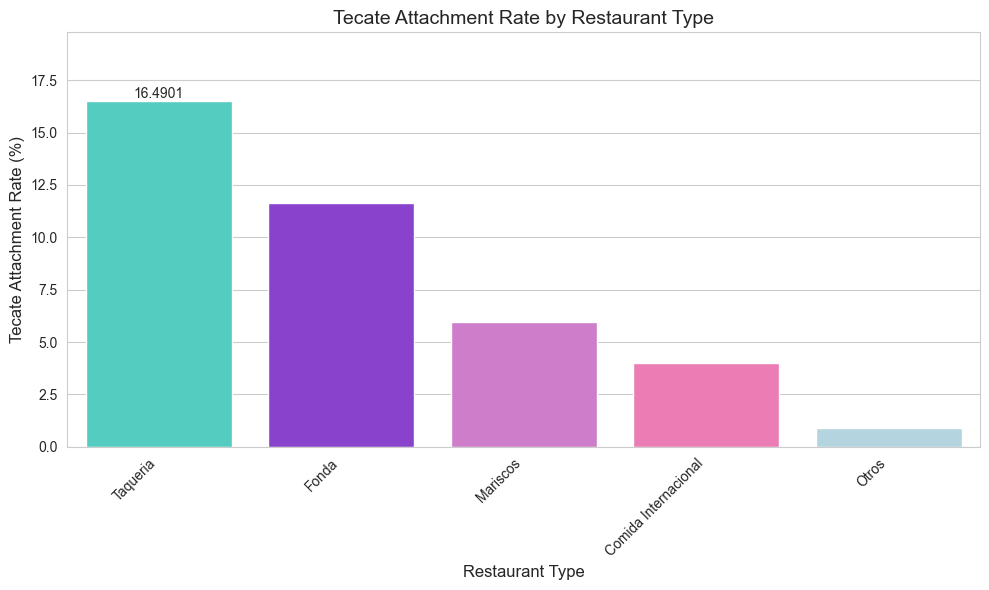

        Restaurant Type        AR%
0              Taqueria  16.490142
1                 Fonda  11.654339
2              Mariscos   5.971533
3  Comida Internacional   4.023030
4                 Otros   0.882923


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define restaurant types
restaurant_types = ['Taqueria', 'Fonda', 'Mariscos', 'Comida Internacional', 'Otros']
num_types = len(restaurant_types)

# Create a DataFrame
df_types = pd.DataFrame(restaurant_types, columns=['Restaurant Type'])

# Generate AR% values based on restaurant type (using normal distribution)
np.random.seed(42)  # for reproducibility
df_types['AR%'] = [
    np.random.normal(loc=15, scale=3, size = 1)[0],  # Taqueria (highest)
    np.random.normal(loc=12, scale=2.5, size = 1)[0],  # Fonda (high)
    np.random.normal(loc=5, scale=1.5, size = 1)[0],  # Mariscos (medium)
    np.random.normal(loc=2.5, scale=1, size = 1)[0],  # Comida Internacional (low)
    np.random.normal(loc=1, scale=0.5, size = 1)[0]   # Otros (lowest)
]

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
colors = ["#40E0D0", "#8A2BE2", "#DA70D6", "#FF69B4", "#ADD8E6"]
ax = sns.barplot(x='Restaurant Type', y='AR%', data=df_types, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tecate Attachment Rate (%)', fontsize=12)
plt.xlabel('Restaurant Type', fontsize=12)
plt.title('Tecate Attachment Rate by Restaurant Type', fontsize=14)
plt.ylim(0, df_types['AR%'].max()*1.2)
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

print(df_types)